In [ ]:
import numpy as np

In [ ]:
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [ ]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [ ]:
w[0:4:2]

array([2, 5])

In [ ]:
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [ ]:
from scipy.signal import convolve

In [ ]:
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [ ]:
from scipy.signal import correlate

In [ ]:
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [ ]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [ ]:
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [ ]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])

In [ ]:
from scipy.signal import correlate2d

correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [ ]:
np.flip(w)

array([[0, 0],
       [0, 2]])

In [ ]:
from scipy.signal import convolve2d

convolve2d(x, w, mode='valid')

array([[10, 12],
       [16, 18]])

In [ ]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [ ]:
import tensorflow as tf

In [ ]:
x_4d = x.astype(float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

In [ ]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [ ]:
x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

In [ ]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [ ]:
def relu(x):
    return np.maximum(x, 0)

In [ ]:
x = np.array([-1, 2, -3, 4, -5])

relu(x)

array([0, 2, 0, 4, 0])

In [ ]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

In [ ]:
import tensorflow as tf

class ConvolutionNetwork:

    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))

    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.

    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [ ]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = x ** 3 + 2 * x + 5

# 그래디언트를 계산합니
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [ ]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = tf.nn.softmax(x)

# 그래디언트를 계산합니다.
print(tape.gradient(y, x))

tf.Tensor([9.99540153e-18 2.71703183e-17 7.38565826e-17], shape=(3,), dtype=float64)


In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all,
                                                  test_size=0.2, random_state=42)

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [ ]:
x_train.shape

(48000, 28, 28, 1)

In [ ]:
x_train = x_train / 255
x_val = x_val / 255

In [ ]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded,
       x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

In [ ]:
import matplotlib.pyplot as plt

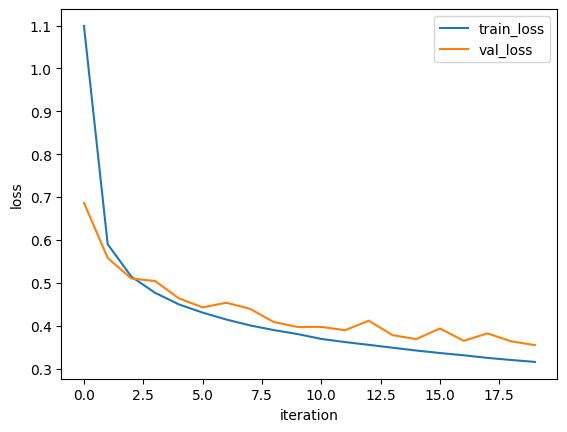

In [ ]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
cn.score(x_val, y_val_encoded)

0.87525

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv1.add(MaxPooling2D((2, 2)))
conv1.add(Flatten())
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [ ]:
conv1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 10)          │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1960)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         196,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,210 (770.35 KB)

 Trainable params: 197,210 (770.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = conv1.fit(x_train, y_train_encoded, epochs=20,
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7927 - loss: 0.5892 - val_accuracy: 0.8840 - val_loss: 0.3192
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8882 - loss: 0.3032 - val_accuracy: 0.8971 - val_loss: 0.2804
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9045 - loss: 0.2534 - val_accuracy: 0.8992 - val_loss: 0.2703
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9179 - loss: 0.2258 - val_accuracy: 0.9070 - val_loss: 0.2530
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9270 - loss: 0.1982 - val_accuracy: 0.9029 - val_loss: 0.2726
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9352 - loss: 0.1749 - val_accuracy: 0.9168 - val_loss: 0.2434
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9436 - loss: 0.1542 - val_accuracy: 0.9107 - val_loss: 0.2572
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9472 - loss: 0.1414 - 

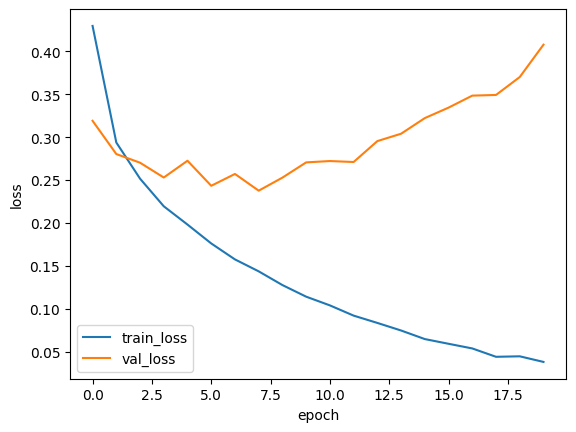

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

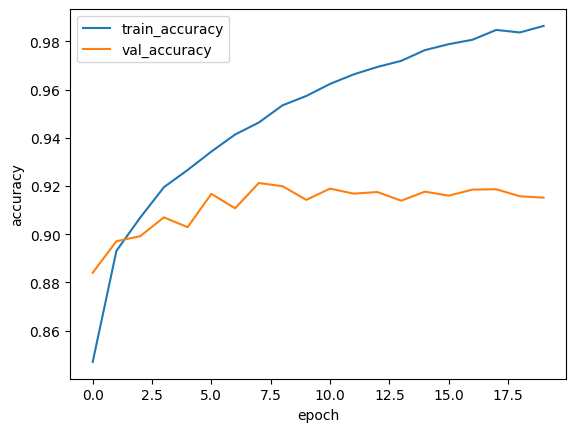

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = conv1.evaluate(x_val, y_val_encoded, verbose=0)

In [ ]:
print(accuracy)

0.9151666760444641


In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [ ]:
conv2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 10)          │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1960)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1960)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │         196,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,210 (770.35 KB)

 Trainable params: 197,210 (770.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = conv2.fit(x_train, y_train_encoded, epochs=20,
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7596 - loss: 0.6828 - val_accuracy: 0.8758 - val_loss: 0.3544
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8588 - loss: 0.3888 - val_accuracy: 0.8907 - val_loss: 0.3037
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8718 - loss: 0.3440 - val_accuracy: 0.8937 - val_loss: 0.2870
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8862 - loss: 0.3130 - val_accuracy: 0.8981 - val_loss: 0.2773
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8949 - loss: 0.2839 - val_accuracy: 0.9050 - val_loss: 0.2604
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9015 - loss: 0.2668 - val_accuracy: 0.9027 - val_loss: 0.2621
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9008 - loss: 0.2659 - val_accuracy: 0.9062 - val_loss: 0.2582
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9049 - loss: 0.2511 - 

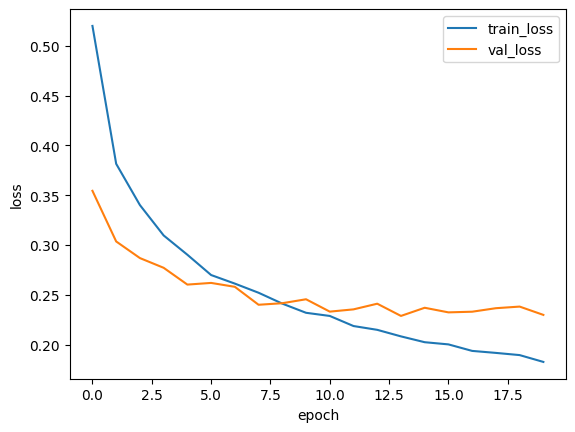

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

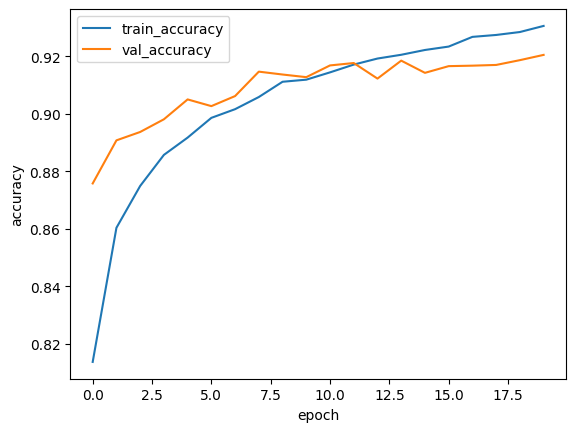

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = conv2.evaluate(x_val, y_val_encoded, verbose=0)

In [ ]:
print(accuracy)

0.9204999804496765
